In [20]:
import numpy as np
import torch
import os, sys
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.mechanism_base import *

# This is the primary function you asked to change.
def gradient_update(theta, xi, p, device):
    """
    Computes the sum of gradients over all frequency modes k.
    """
    # Compute Fourier coefficients for theta and xi once
    fourier_basis, _ = get_fourier_basis(p, device)
    fourier_basis = fourier_basis.to(theta.dtype)
    theta_coeff = fourier_basis @ theta  
    xi_coeff    = fourier_basis @ xi

    # Initialize total gradients to zero tensors with the correct shape and device
    total_grad_theta = torch.zeros_like(theta)
    total_grad_xi = torch.zeros_like(xi)
    
    # Create a tensor for the spatial coordinate 'j'
    j_values = torch.arange(p, device=device, dtype=theta.dtype)

    factor = np.sqrt(2.0 / p)

    # Loop over all frequency modes k from 1 up to p/2.
    # We start from k=1 because k=0 (the DC component) is a single coefficient,
    # whereas the logic for alpha/phi requires a pair of sin/cos coefficients.
    for k in range(1, (p-1)//2):
        # --- Extract the 2-coefficient vector for the current k
        coeff_indices = [k * 2 - 1, k * 2]
        neuron_coeff_theta = theta_coeff[coeff_indices]
        neuron_coeff_xi = xi_coeff[coeff_indices]
        
        # --- Calculate alpha, phi, beta, and psi for the current k using torch
        alpha = factor * torch.norm(neuron_coeff_theta, dim=0)
        phi = torch.arctan2(-neuron_coeff_theta[1], neuron_coeff_theta[0])
        
        beta = factor * torch.norm(neuron_coeff_xi, dim=0)
        psi = torch.arctan2(-neuron_coeff_xi[1], neuron_coeff_xi[0])

        # --- Compute gradients for the current k
        w_k = 2 * np.pi * k / p
        grad_theta_k = 2 * p * alpha * beta * torch.cos(w_k * j_values + psi - phi)
        grad_xi_k = p * alpha.pow(2) * torch.cos(w_k * j_values + 2 * phi)
        
        # --- Add the gradients for this k to the total sum
        total_grad_theta += grad_theta_k / p**2
        total_grad_xi += grad_xi_k / p**2

    return total_grad_theta, total_grad_xi

# The simulation function is updated to use the new gradient function.
def simulate_gradient_flow(theta, xi, p, num_steps, learning_rate, device):
    theta_history = [theta.clone()]
    xi_history = [xi.clone()]
    
    for step in range(num_steps):
        # Call the new gradient_update function (init_k is no longer needed)
        grad_theta, grad_xi = gradient_update(theta, xi, p, device)
        
        # Update parameters
        theta = theta + learning_rate * grad_theta
        xi = xi + learning_rate * grad_xi
        
        theta_history.append(theta.clone())
        xi_history.append(xi.clone())
        
    return theta_history, xi_history

def analyze_history(theta_history, xi_history, p, fourier_basis):
    """
    Analyzes the full simulation history to extract alpha, beta, phi, psi,
    and delta for all frequency modes k.
    """
    print("Analyzing simulation history...")
    theta_hist_tensor = torch.stack(theta_history)
    xi_hist_tensor = torch.stack(xi_history)

    theta_coeffs_hist = fourier_basis @ theta_hist_tensor.T
    xi_coeffs_hist = fourier_basis @ xi_hist_tensor.T

    results = {
        'alphas': {}, 'phis': {}, 'betas': {}, 'psis': {}, 'deltas': {}
    }
    factor = np.sqrt(2.0 / p)

    for k in range(1, (p - 1) // 2 + 1):
        idx = [k * 2 - 1, k * 2]
        neuron_theta_hist = theta_coeffs_hist[idx, :]
        neuron_xi_hist = xi_coeffs_hist[idx, :]

        alphas_k = factor * torch.norm(neuron_theta_hist, dim=0)
        phis_k = torch.atan2(-neuron_theta_hist[1, :], neuron_theta_hist[0, :])
        
        betas_k = factor * torch.norm(neuron_xi_hist, dim=0)
        psis_k = torch.atan2(-neuron_xi_hist[1, :], neuron_xi_hist[0, :])
        
        deltas_k = normalize_to_pi(2 * phis_k - psis_k)

        results['alphas'][k] = alphas_k.numpy()
        results['phis'][k] = phis_k.numpy()
        results['betas'][k] = betas_k.numpy()
        results['psis'][k] = psis_k.numpy()
        results['deltas'][k] = deltas_k.numpy()

    print("Analysis complete.")
    return results


def plot_results(results, num_steps, lr, init_k):
    """
    Visualizes the dynamics by grouping magnitudes and phases onto shared plots.
    """
    print("Generating plots...")
    
    # Define labels for all potential quantities
    labels = {
        'alpha': r'$\alpha_{k=%d}$' % init_k, 'beta': r'$\beta_{k=%d}$' % init_k,
        'phi': r'$\phi_{k=%d}$' % init_k,   'psi': r'$\psi_{k=%d}$' % init_k,
        'delta': r'$\delta_{k=%d}$' % init_k
    }
    
    time_steps = np.arange(num_steps + 1) * lr
    
    # Create a figure with 2 rows of subplots
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
    
    ax_mag = axes[0]  # Axis for magnitudes (alpha, beta)
    ax_phase = axes[1] # Axis for phases (delta, phi, psi)

    # --- 1. Plot Magnitudes (alpha and beta) on the first subplot ---
    # Plot muted lines for all other frequencies first
    for k in range(1, (config['p'] - 1) // 2 + 1):
        if k != init_k:
            ax_mag.plot(time_steps, results['alphas'][k], lw=1.5, alpha=0.4, color='gray')
            ax_mag.plot(time_steps, results['betas'][k], lw=1.5, alpha=0.4, color='gray', linestyle='--')

    # Plot highlighted lines for init_k on top
    ax_mag.plot(time_steps, results['alphas'][init_k], lw=2.5, label=labels['alpha'])
    ax_mag.plot(time_steps, results['betas'][init_k], lw=2.5, label=labels['beta'], linestyle='--')
    
    ax_mag.set_ylabel('Magnitude')
    ax_mag.grid(True, linestyle='--', alpha=0.6)
    ax_mag.legend()

    # --- 2. Plot Phases (delta, phi, psi) on the second subplot ---
    # Plot muted lines for other frequencies
    for k in range(1, (config['p'] - 1) // 2 + 1):
        if k != init_k:
            ax_phase.plot(time_steps, results['deltas'][k], lw=1.5, alpha=0.4, color='gray')

    # Plot highlighted line for init_k delta
    ax_phase.plot(time_steps, results['deltas'][init_k], lw=2.5, label=labels['delta'], color='green')
    
    # (Optional) Uncomment the lines below to also plot phi and psi
    ax_phase.plot(time_steps, results['phis'][init_k]*2, lw=2.0, label=labels['phi'], color='purple', linestyle=':')
    ax_phase.plot(time_steps, results['psis'][init_k], lw=2.0, label=labels['psi'], color='brown', linestyle=':')

    ax_phase.set_ylabel('Phase (radians)')
    ax_phase.grid(True, linestyle='--', alpha=0.6)
    ax_phase.legend()

    # --- Final Touches ---
    ax_phase.set_xlabel('Time')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [10]:
# --- Simulation Parameters ---
config = {
    "p": 23,
    "init_k": 2,         # The mode to initialize with non-zero amplitude
    "num_steps": 7000,
    "learning_rate": 0.1,
    "init_phi": -0.72,
    "init_psi": -2.91,
    "amplitude": 0.02,
    "device": torch.device("cpu")
}
# Use float64 for higher precision if needed
torch.set_default_dtype(torch.float64)

# --- Initialization ---
fourier_basis, _ = get_fourier_basis(config['p'], config['device'])
w_k = 2 * np.pi * config['init_k'] / config['p']

theta_init = config['amplitude'] * torch.tensor(
    [np.cos(w_k * j + config['init_phi']) for j in range(config['p'])],
    device=config['device']
)
xi_init = config['amplitude'] * torch.tensor(
    [np.cos(w_k * j + config['init_psi']) for j in range(config['p'])],
    device=config['device']
)

# --- Run Simulation ---
print(f"Running simulation for {config['num_steps']} steps...")
theta_history, xi_history = simulate_gradient_flow(
    theta_init, xi_init, config['p'], config['num_steps'], 
    config['learning_rate'], config['device']
)
print("Simulation finished.")

# --- Analyze & Visualize ---
results_history = analyze_history(theta_history, xi_history, config['p'], fourier_basis)

Running simulation for 7000 steps...
Simulation finished.
Analyzing simulation history...
Analysis complete.


In [6]:
# Define the base path where the model and data files are stored
base_path = '../src/saved_models/p_23_dmlp_512_Quad_single-freq_scale_0.02_decay_0_08151819' # Full random, ReLU, Small Init, AdamW

# Set model configuration parameters
d_vocab, d_model, d_mlp, act_type = 23, 23, 512, 'ReLU'  # Vocabulary size, model dimension, MLP size, and activation type
p = d_vocab  # Assign vocabulary size to variable `p`

all_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if os.path.isfile(os.path.join(base_path, f))]

loaded_files = {} # Initialize the dictionary to store the loaded files
exclude_files = {'final.pth', 'test_data.pth', 'train_data.pth'} # Define the files to exclude

# Loop through all files in the directory
for file_name in os.listdir(base_path):
    file_path = os.path.join(base_path, file_name)
    # Check if it's a file, has the correct extension, and is not in the exclude list
    if os.path.isfile(file_path) and file_name.endswith('.pth') and file_name not in exclude_files:
        # Extract the final ID from the filename (remove extension and convert to int)
        final_id = int(os.path.splitext(file_name)[0])
        # Load the file (assuming it's a PyTorch model)
        loaded_files[final_id] = torch.load(file_path, weights_only=True, map_location=device)["model"]
loaded_files = {key: loaded_files[key] for key in sorted(loaded_files)}

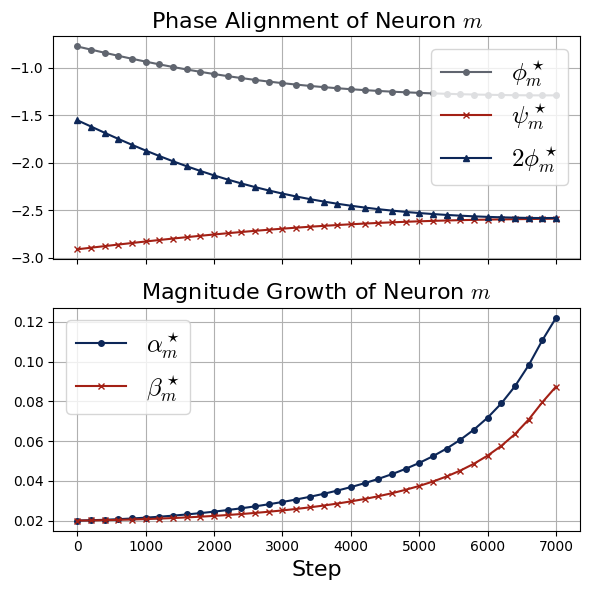

In [12]:
# Create a single list of all neuron‐records (dropping the model key)
all_neuron_records = []
sparse_level_ls =[]

for model in loaded_files.values():
    # Ensure fourier_basis has the same dtype as the model weights
    model_dtype = model['mlp.W_in'].dtype
    fourier_basis_aligned = fourier_basis.to(dtype=model_dtype)
    
    # Decode this model's weights
    W_in_decode, W_out_decode, max_freq_ls = decode_weights(model, fourier_basis_aligned)
    d_mlp = W_in_decode.shape[0]
    sparse_level_ls.append((W_in_decode.norm(p=4, dim=1)**4/W_in_decode.norm(p=2, dim=1)**4).mean()/2 + (W_out_decode.norm(p=4, dim=1)**4/W_out_decode.norm(p=2, dim=1)**4).mean()/2)

    for neuron in range(d_mlp):
        coeff_in_scale, coeff_in_phi  = compute_neuron(neuron, max_freq_ls, W_in_decode)
        coeff_out_scale, coeff_out_phi = compute_neuron(neuron, max_freq_ls, W_out_decode)
        scale_diff = coeff_in_scale**2 - 2 * coeff_out_scale**2

        # Append just the neuron‐level info
        all_neuron_records.append({
            "neuron":     neuron,
            "frequency":  max_freq_ls[neuron],
            "scale_in":   coeff_in_scale,
            "phi_in":     coeff_in_phi,
            "scale_out":  coeff_out_scale,
            "phi_out":    coeff_out_phi,
            "scale_diff": scale_diff
        })

# Rebuild the lists for neuron 35 (assumes all_neuron_records exists)
neuron_records = [r for r in all_neuron_records if r["neuron"] == 1][:-14]

phi_in_list    = [r["phi_in"]    for r in neuron_records]
phi_out_list   = [r["phi_out"]   for r in neuron_records]
phi2_in_list   = [2 * v          for v in phi_in_list]
scale_in_list  = [r["scale_in"]  for r in neuron_records]
scale_out_list = [r["scale_out"] for r in neuron_records]

# X-axis scaled by 1000
x = np.arange(len(phi_in_list)) * 200

colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']
plt.rcParams['mathtext.fontset'] = 'cm'

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

ax1.plot(x, phi_in_list,  marker='o', markersize=4, color=colors[1], label=r"$\phi_m^\star$")
ax1.plot(x, phi_out_list, marker='x', markersize=4, color=colors[3], label=r"$\psi_m^\star$")
ax1.plot(x, phi2_in_list, marker='^', markersize=4, color=colors[0], label=r"$2\phi_m^\star$")
ax1.set_title('Phase Alignment of Neuron $m$', fontsize=16)
ax1.legend(fontsize=18, loc="upper right")
ax1.grid(True)

ax2.plot(x, scale_in_list,  marker='o', markersize=4, color=colors[0], label=r"$\alpha_m^\star$")
ax2.plot(x, scale_out_list, marker='x', markersize=4, color=colors[3], label=r"$\beta_m^\star$")
ax2.set_title('Magnitude Growth of Neuron $m$', fontsize=16)
ax2.set_xlabel('Step', fontsize=16)
ax2.legend(fontsize=18, loc="upper left")
ax2.grid(True)

plt.tight_layout()
plt.show()

Generating plots...


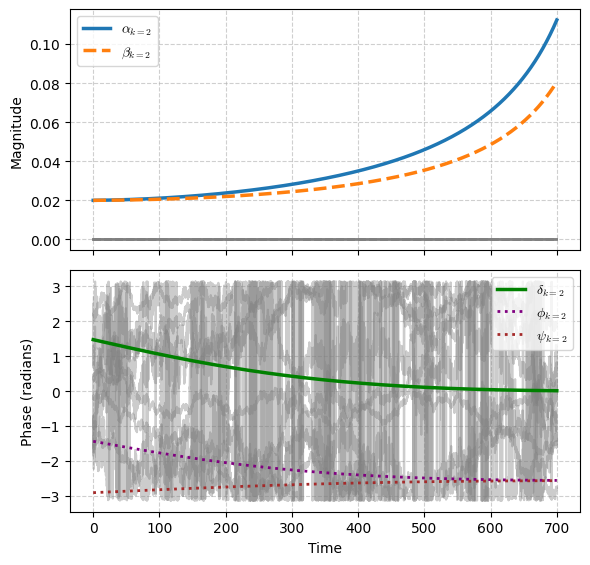

In [14]:
# MODIFIED: Pass init_k to the plotting function
plot_results(results_history, config['num_steps'], config['learning_rate'], config['init_k'])

In [42]:
def publish_plot(results, num_steps, lr, init_k):
    """
    Generates a publication-quality plot with three subplots visualizing
    the dynamics of phase alignment, phase difference, and magnitude evolution.

    Args:
        results (dict): A dictionary containing the simulation results, including
                        'alphas', 'betas', 'deltas', 'phis', and 'psis'.
        num_steps (int): The total number of simulation steps.
        lr (float): The learning rate, used to calculate the time axis.
        init_k (int): The specific frequency index to highlight in the plots.
    """
    print("Generating publication plot...")

    # --- 1. Setup and Data Extraction ---
    # Define colors and font settings for the plot
    colors = ['#0D2758', '#60656F', '#DEA54B', '#A32015', '#347186']
    plt.rcParams['mathtext.fontset'] = 'cm'

    # Extract the specific data arrays for the chosen frequency k
    # Ensure data is numpy array for plotting
    alphas = np.array(results['alphas'][init_k])
    betas = np.array(results['betas'][init_k])
    deltas = np.array(results['deltas'][init_k])
    phis = np.array(results['phis'][init_k])
    psis = np.array(results['psis'][init_k])

    # Create the time axis for the plots
    x = np.arange(num_steps + 1) * lr
    
    # Define properties for the vertical line annotation
    vline_x = 30
    vline_kwargs = dict(color='gray', linestyle='--', linewidth=1.5)

    # --- 2. Create Subplots ---
    # Initialize a figure with 3 rows of subplots that share the x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 9), sharex=True)

    # --- 3. Plot 1: Dynamics of Phase Alignment ---
    ax1.plot(x, psis, color=colors[3], linewidth=2.5, label=r"$\psi_m^\star$")
    ax1.plot(x, phis * 2, linewidth=2.5, color=colors[0], label=r"$2\phi_m^\star$")
    #ax1.axvline(x=vline_x, **vline_kwargs)
    ax1.set_title('Dynamics of Phase Alignment', fontsize=18)
    ax1.set_ylabel('Phase (radians)', fontsize=14)
    ax1.legend(fontsize=18)
    ax1.grid(True)

    # --- 4. Plot 2: Dynamics of Phase Difference ---
    ax2.plot(x, deltas, color=colors[0], linewidth=2.5, label=r"$D_m^\star$")
    #ax2.axvline(x=vline_x, **vline_kwargs)
    #ax2.axhline(y=np.pi/2, **vline_kwargs)  # Horizontal line at y=pi/2
    #ax2.text(x=max(x)*0.05, y=np.pi/2 - 0.4, s=r"$D^\star=\pi/2$", fontsize=16, color='black')
    ax2.set_title('Dynamics of Phase Difference', fontsize=18)
    ax2.set_ylabel('Phase (radians)', fontsize=14)
    ax2.legend(fontsize=18)
    ax2.grid(True)

    # --- 5. Plot 3: Magnitude Evolution ---
    ax3.plot(x, alphas, linewidth=2.5, color=colors[0], label=r"$\alpha_m^\star$")
    ax3.plot(x, betas, linewidth=2.5, color=colors[3], label=r"$\beta_m^\star$")
    #ax3.axvline(x=vline_x, **vline_kwargs)
    ax3.set_title('Magnitude Evolution', fontsize=18)
    ax3.set_xlabel('Time', fontsize=18)
    ax3.set_ylabel('Magnitude', fontsize=14)
    ax3.legend(fontsize=18)
    ax3.grid(True)

    # --- 6. Final Touches ---
    plt.tight_layout()
    # To save the figure, uncomment the following line:
    plt.savefig('../figures/phase_align_approx2.jpg', format='jpg', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
# --- Simulation Parameters ---
config = {
    "p": 23,
    "init_k": 2,         # The mode to initialize with non-zero amplitude
    "num_steps": 7000,
    "learning_rate": 0.1,
    "init_phi": -0.72,
    "init_psi": -2.91,
    "amplitude": 0.02,
    "device": torch.device("cpu")
}
# Use float64 for higher precision if needed
torch.set_default_dtype(torch.float64)

# --- Initialization ---
fourier_basis, _ = get_fourier_basis(config['p'], config['device'])
w_k = 2 * np.pi * config['init_k'] / config['p']

theta_init = config['amplitude'] * torch.tensor(
    [np.cos(w_k * j + config['init_phi']) for j in range(config['p'])],
    device=config['device']
)
xi_init = config['amplitude'] * torch.tensor(
    [np.cos(w_k * j + config['init_psi']) for j in range(config['p'])],
    device=config['device']
)

# --- Run Simulation ---
print(f"Running simulation for {config['num_steps']} steps...")
theta_history, xi_history = simulate_gradient_flow(
    theta_init, xi_init, config['p'], config['num_steps'], 
    config['learning_rate'], config['device']
)
print("Simulation finished.")

# --- Analyze & Visualize ---
results_history = analyze_history(theta_history, xi_history, config['p'], fourier_basis)


Running simulation for 7000 steps...
Simulation finished.
Analyzing simulation history...
Analysis complete.


Generating publication plot...


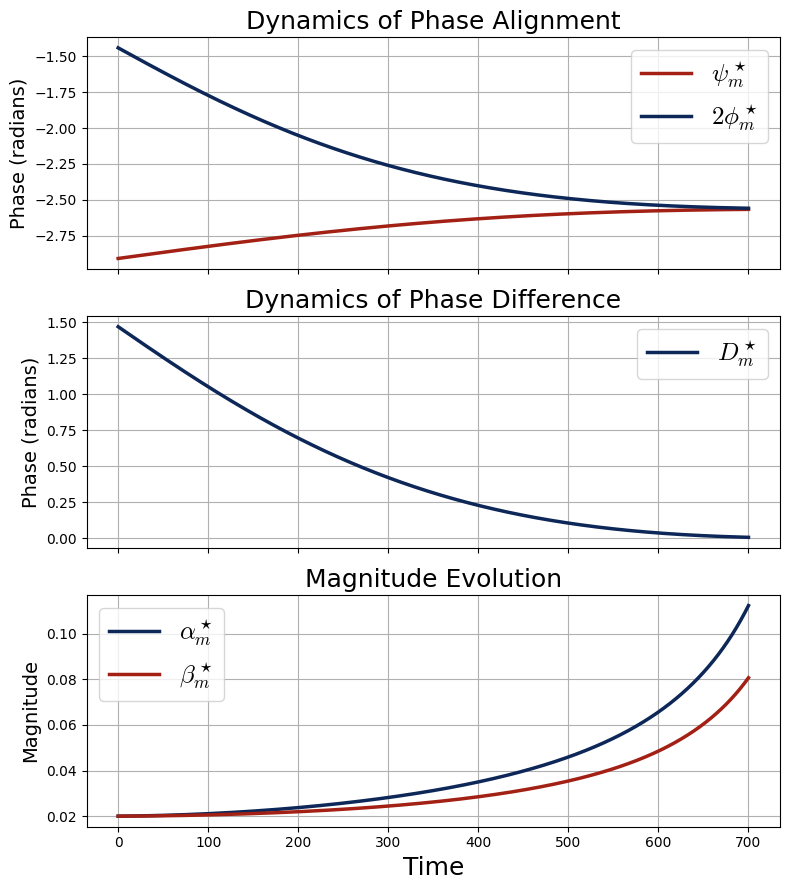

In [43]:
publish_plot(results_history, config['num_steps'], config['learning_rate'], config['init_k'])